# Hybrid CNN-LSTM Model

Design a hybrid architecture that combines 1D Convolutional Layers for local pattern extraction with LSTM layers for temporal sequence learning. This model will aim to improve over pure CNN or LSTM models in capturing both spatial and sequential dependencies in stock price movements.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


`Load Preprocessed Data`

Use the feature-engineered and scaled dataset from 02_feature_engineering.ipynb and data/processed/.

In [16]:
data = pd.read_csv("../data/processed/processed_stock_data.csv", index_col=0)
print(data.shape)
data.head()


(221, 3)


,Close/Last,Target_Close_Next_Day,Daily_Return
Date,,,
2023-10-19,220.11,211.99,-22.57
2023-10-20,211.99,212.08,-8.12
2023-10-23,212.08,216.52,0.09
2023-10-24,216.52,212.42,4.44
2023-10-25,212.42,205.76,-4.10


`Create Sequences for CNN-LSTM`

Use sliding windows to create time sequences.

In [17]:
def create_sequences(data, target_column, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i - window_size:i].values)
        y.append(data.iloc[i-1][target_column])
    return np.array(X), np.array(y)

# Define target and features
target_column = 'Target_Close_Next_Day'
features = data.drop(columns=['Target_Close_Next_Day'])  # remove target

# Scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(pd.concat([features, data[[target_column]]], axis=1))
scaled_df = pd.DataFrame(scaled_data, columns=list(features.columns) + [target_column])

# Create sequences
window_size = 3
X, y = create_sequences(scaled_df, target_column, window_size)

# Reshape for Conv1D: (samples, timesteps, features)
print(f"✅ X shape: {X.shape} | y shape: {y.shape}")


✅ X shape: (218, 3, 3) | y shape: (218,)


`Train-Test Split`

In [18]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


`Build Hybrid CNN-LSTM Model`

In [19]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 1, 64)          │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,729 (131.75 KB)

 Trainable params: 33,729 (131.75 KB)

 Non-trainable params: 0 (0.00 B)

`Train the Model`

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0096 - val_loss: 0.0062
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0078 - val_loss: 0.0055
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0093 - val_loss: 0.0057
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0071 - val_loss: 0.0059
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0067 - val_loss: 0.0057
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0056 - val_loss: 0.0060
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0066 - val_loss: 0.0056
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0077 - val_lo

`Evaluation (Inverse Scaling)`

In [24]:
# Predict
y_pred = model.predict(X_test)

# Reshape for inverse transform
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

# Create dummy 2D arrays (same trick as LSTM)
y_pred_dummy = np.zeros((len(y_pred), scaled_df.shape[1]))
y_test_dummy = np.zeros((len(y_test), scaled_df.shape[1]))
y_pred_dummy[:, -1] = y_pred_reshaped[:, 0]
y_test_dummy[:, -1] = y_test_reshaped[:, 0]

# Inverse transform only the target
y_pred_inv = scaler.inverse_transform(y_pred_dummy)[:, -1]
y_test_inv = scaler.inverse_transform(y_test_dummy)[:, -1]

# Metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"\u2705 Hybrid CNN-LSTM MAE (Real Price): {mae:.2f}")
print(f"\u2705 Hybrid CNN-LSTM RMSE (Real Price): {rmse:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
✅ Hybrid CNN-LSTM MAE (Real Price): 5.53
✅ Hybrid CNN-LSTM RMSE (Real Price): 6.94


`Plot Results`

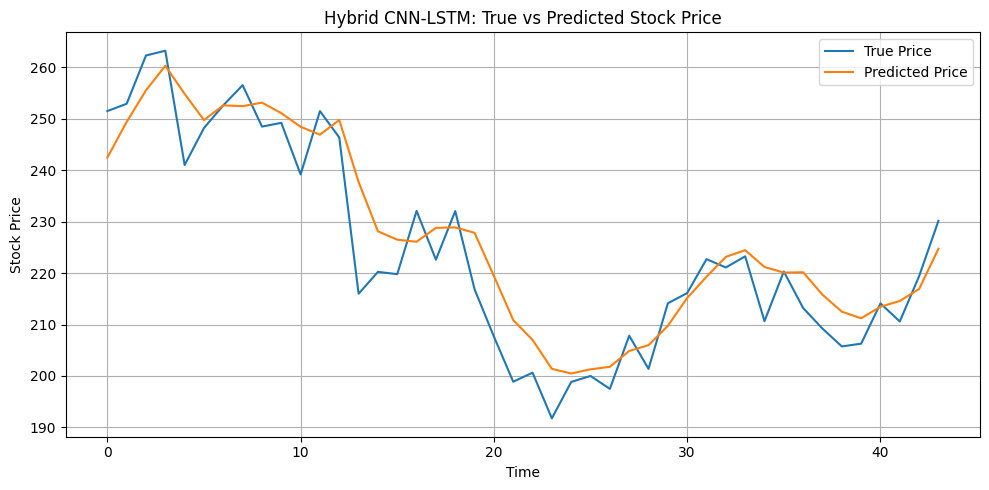

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label="True Price")
plt.plot(y_pred_inv, label="Predicted Price")
plt.title("Hybrid CNN-LSTM: True vs Predicted Stock Price")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


`Saved Model`

In [27]:
model.save("../saved_models/hybrid_cnn_lstm_model.h5")
